<a href="https://colab.research.google.com/github/sylvas-j/ML/blob/master/Tensorflow_works/SmartHome_ModelProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# multi-class classification with Keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder,LabelEncoder,MinMaxScaler
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils

In [3]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
from sklearn.svm import LinearSVR

In [4]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# import mitosheet

#### For Google Colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Ms Imumisen/smart_home_ds.csv")

#### For Jupyter Lab

In [ ]:
data= pd.read_csv('D:\\Desktop Files\\weka data\\Ms Imumu\\hh130\\hh130.ann.features.csv')

In [ ]:
mitosheet.sheet(data)

MitoWidget(analysis_name='UUID-716c6500-92c2-499a-8c65-195f4a60998b', code_json='{"imports": "from mitosheet i…

In [ ]:
# MITO CODE START (DO NOT EDIT)

from mitosheet import * # Import necessary functions from Mito
register_analysis('UUID-716c6500-92c2-499a-8c65-195f4a60998b') # Let Mito know which analysis is being run

# Pivoted data into df2
df2 = pd.DataFrame(data={})

  
# MITO CODE END (DO NOT EDIT)

#### Data Wrangling and Processing

https://machinelearningmastery.com/data-preparation-techniques-for-machine-learning/

##### Data Cleaning: Identifying and correcting mistakes or errors in the data.
##### Feature Selection: Identifying those input variables that are most relevant to the task.
##### Data Transforms: Changing the scale or distribution of variables.
##### Feature Engineering: Deriving new variables from available data.
##### Dimensionality Reduction: Creating compact projections of the data.

In [ ]:
data.head(4)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
0,2.0,7371.0,3.0,5722.0,1.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
1,2.0,7373.0,3.0,5723.0,2.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
2,2.0,7374.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
3,2.0,7375.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep


In [114]:
# Shuffled dataset and divide into dependent and independent set
data_shuffled = data.sample(frac=1)

X_df = data_shuffled.drop(labels=['activity'], axis=1)
y_df = data_shuffled['activity']

In [7]:
y_df

0         Sleep
1         Sleep
2         Sleep
3         Sleep
4         Sleep
          ...  
157367    Sleep
157368    Sleep
157369    Sleep
157370    Sleep
157371    Sleep
Name: activity, Length: 157372, dtype: object

In [8]:
data.corr()

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
lastSensorEventHours,1.000000,0.998581,0.004958,-0.095645,-0.034804,0.200807,0.211911,0.133822,0.133822,0.148368,-0.034145,-0.005037,-0.021128,NaN,-0.112535,-0.134686,NaN,NaN,NaN,-0.047892,0.060029,0.244983,NaN,-0.010620,NaN,0.013302,0.161494,NaN,NaN,NaN,-0.148280,-0.286113,-0.266812,NaN,-0.118630,NaN
lastSensorEventSeconds,0.998581,1.000000,0.008052,-0.095057,-0.034541,0.200550,0.212061,0.132898,0.132898,0.147273,-0.035576,-0.005036,-0.022218,NaN,-0.110391,-0.135517,NaN,NaN,NaN,-0.047981,0.057927,0.245140,NaN,-0.011126,NaN,0.013728,0.161934,NaN,NaN,NaN,-0.148465,-0.285706,-0.266068,NaN,-0.118501,NaN
lastSensorDayOfWeek,0.004958,0.008052,1.000000,0.000474,0.001162,0.006574,0.005843,0.001191,0.001191,0.007354,-0.019884,-0.001008,-0.000396,NaN,0.011507,-0.009989,NaN,NaN,NaN,-0.029220,-0.005670,0.025060,NaN,-0.013449,NaN,-0.004421,-0.005140,NaN,NaN,NaN,0.000172,0.014175,0.043468,NaN,-0.015185,NaN
windowDuration,-0.095645,-0.095057,0.000474,1.000000,0.314408,-0.029632,-0.064792,0.021350,0.021350,0.036138,-0.313383,0.002748,-0.267356,NaN,-0.194275,0.135004,NaN,NaN,NaN,0.220572,-0.113131,-0.033380,NaN,0.001944,NaN,0.465764,0.354940,NaN,NaN,NaN,0.244148,0.192892,0.267309,NaN,0.471406,NaN
timeSinceLastSensorEvent,-0.034804,-0.034541,0.001162,0.314408,1.000000,-0.017921,-0.024935,0.015274,0.015274,0.031614,-0.101922,-0.142090,-0.079354,NaN,-0.067537,0.066774,NaN,NaN,NaN,0.043174,-0.038333,-0.014349,NaN,0.008017,NaN,0.131032,0.136262,NaN,NaN,NaN,0.099280,0.056365,0.083470,NaN,0.143315,NaN
prevDominantSensor1,0.200807,0.200550,0.006574,-0.029632,-0.017921,1.000000,0.477181,0.213728,0.213728,0.243117,0.075762,0.023516,0.021851,NaN,-0.272519,-0.240109,NaN,NaN,NaN,0.069521,0.182175,0.358118,NaN,0.014852,NaN,0.131014,0.191512,NaN,NaN,NaN,-0.076687,-0.222831,-0.174772,NaN,-0.032458,NaN
prevDominantSensor2,0.211911,0.212061,0.005843,-0.064792,-0.024935,0.477181,1.000000,0.152658,0.152658,0.170010,0.059542,0.012621,-0.003392,NaN,-0.132939,-0.197280,NaN,NaN,NaN,0.047996,0.131385,0.221019,NaN,0.020648,NaN,0.101285,0.151134,NaN,NaN,NaN,-0.077511,-0.225039,-0.179830,NaN,-0.044066,NaN
lastSensorID,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastSensorLocation,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastMotionLocation,0.148368,0.147273,0.007354,0.036138,0.031614,0.243117,0.170010,0.858334,0.858334,1.000000,0.122533,-0.070205,0.027712,NaN,-0.473448,-0.258489,NaN,NaN,NaN,0.110256,0.215386,0.466225,NaN,0.174744,NaN,0.102679,0.253689,NaN,NaN,NaN,-0.071910,-0.196571,-0.180780,NaN,-0.072909,NaN


In [9]:
data.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, lastSensorEventHours to sensorElTime-WorkArea
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lastSensorEventHours      25 non-null     float64
 1   lastSensorEventSeconds    25 non-null     float64
 2   lastSensorDayOfWeek       25 non-null     float64
 3   windowDuration            25 non-null     float64
 4   timeSinceLastSensorEvent  25 non-null     float64
 5   prevDominantSensor1       25 non-null     float64
 6   prevDominantSensor2       25 non-null     float64
 7   lastSensorID              25 non-null     float64
 8   lastSensorLocation        25 non-null     float64
 9   lastMotionLocation        25 non-null     float64
 10  complexity                25 non-null     float64
 11  activityChange            25 non-null     float64
 12  areaTransitions           25 non-null     float64
 13  numDistinctSensors        0 non-nu

In [10]:
corr_data = data.corr()

#### Filtering Columns with Contant Values

In [115]:
# Execute the following script to create a filter for constant features.
constant_filter = VarianceThreshold(threshold=0)
# Next, we need to simply apply this filter to our training set as shown in the following example:
constant_filter.fit(X_df)

VarianceThreshold(threshold=0)

In [116]:
# Execute the following script to see the number of non-constant features.

len(X_df.columns[constant_filter.get_support()])

25

In [117]:
# List of contants column
constant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[constant_filter.get_support()]]

In [118]:
constant_columns

['numDistinctSensors',
 'sensorCount-Chair',
 'sensorCount-DiningRoom',
 'sensorCount-Hall',
 'sensorCount-Office',
 'sensorCount-WorkArea',
 'sensorElTime-Chair',
 'sensorElTime-DiningRoom',
 'sensorElTime-Hall',
 'sensorElTime-Office',
 'sensorElTime-WorkArea']

In [14]:
X_df.head(2)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
0,2.0,7371.0,3.0,5722.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.498951,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0
1,2.0,7373.0,3.0,5723.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.710117,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0


In [119]:
# Finally, to remove constant features from training and test sets, we can use the transform() method of the constant_filter. 
# Execute the following script to do so:

# X_filtered = constant_filter.transform(X_df)
# test_features = constant_filter.transform(test_features)
# X_filtered.shape

# Executing this and skip transform if you want to filter quasi-constant before transform
X_df.drop(labels=constant_columns, axis=1, inplace=True)

In [16]:
X_df

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor
0,2.0,7371.0,3.0,5722.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.498951,0.0,0.0,34.35,0.0,0.0,0.0,0.0,86400.000000,0.0,86400.000000,86400.000000,86400.000000,86400.000000
1,2.0,7373.0,3.0,5723.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.710117,0.0,0.0,34.35,0.0,0.0,0.0,0.0,86400.000000,0.0,86400.000000,86400.000000,86400.000000,86400.000000
2,2.0,7374.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698508,0.0,0.0,34.35,0.0,0.0,0.0,0.0,86400.000000,0.0,86400.000000,86400.000000,86400.000000,86400.000000
3,2.0,7375.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698326,0.0,0.0,34.35,0.0,0.0,0.0,0.0,86400.000000,0.0,86400.000000,86400.000000,86400.000000,86400.000000
4,2.0,7378.0,3.0,5416.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.693501,0.0,0.0,34.35,0.0,0.0,0.0,0.0,86400.000000,0.0,86400.000000,86400.000000,86400.000000,86400.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157367,23.0,84552.0,4.0,455.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.927473,0.0,0.0,34.35,0.0,0.0,0.0,0.0,492.219250,0.0,490.229852,16025.198988,1148.163531,491.263279
157368,23.0,84607.0,4.0,510.0,55.0,0.0,0.0,1.0,1.0,1.0,0.0,0.835294,0.0,0.0,34.35,0.0,0.0,0.0,0.0,547.255265,0.0,545.265867,16080.235003,1203.199546,546.299294
157369,23.0,84608.0,4.0,510.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.835294,0.0,0.0,34.35,0.0,0.0,0.0,0.0,548.281148,0.0,546.291750,16081.260886,1204.225429,547.325177
157370,23.0,85309.0,4.0,1208.0,701.0,0.0,0.0,1.0,1.0,1.0,0.0,0.350993,0.0,0.0,34.35,0.0,0.0,0.0,0.0,1248.987680,0.0,1246.998282,16781.967418,1904.931961,1248.031709


#### Filtering Out Of Contant-filteres dataset quasi-constant

In [120]:
# Let's create our quasi-constant filter. Execute the following script to do so:
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(X_df)

VarianceThreshold(threshold=0.01)

In [121]:
len(X_df.columns[qconstant_filter.get_support()])

25

In [122]:
qconstant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

0


In [123]:
for column in qconstant_columns:
    print(column)

In [124]:
train_features = qconstant_filter.transform(X_df)
# test_features = qconstant_filter.transform(test_features)

train_features.shape

(157372, 25)

#### Removing Duplicate Features

In [125]:
# We will use this method to first take a transpose of our dataset as shown below:
X_T = X_df.T
X_T.shape

(25, 157372)

In [126]:
# Let's find the total number of duplicate features in our dataset using the sum() method, chained with the duplicated() method as shown below.
print(X_T.duplicated().sum())

1


In [127]:
X_T.head(2)
# unique_features.head(2)

,28152,90117,144550,149139,94235,31166,121612,141123,72659,128181,118802,54023,145582,77664,128048,94476,132768,49555,120500,86755,38422,67126,147457,68660,16442,1876,67241,76775,134650,8314,14567,137995,70771,117997,69090,64817,43418,16995,69413,55010,...,116437,8858,1215,101281,18362,2772,141208,21771,49251,37485,77041,93962,60733,23565,44075,24978,52526,143887,116834,112510,93286,155626,85336,79762,73590,104715,23087,104041,40197,19810,109829,5255,147280,151637,94258,83123,154728,92927,22971,113221
lastSensorEventHours,21.0,3.0,21.0,12.0,23.0,12.0,8.0,9.0,8.0,7.0,16.0,14.0,8.0,8.0,7.0,23.0,9.0,18.0,8.0,10.0,17.0,8.0,10.0,8.0,19.0,10.0,8.0,3.0,20.0,7.0,10.0,12.0,18.0,12.0,11.0,15.0,16.0,23.0,11.0,18.0,...,8.0,8.0,8.0,9.0,8.0,10.0,9.0,19.0,16.0,14.0,8.0,22.0,20.0,8.0,19.0,9.0,9.0,18.0,8.0,11.0,18.0,15.0,8.0,11.0,9.0,7.0,23.0,22.0,4.0,11.0,21.0,12.0,10.0,21.0,23.0,15.0,12.0,16.0,22.0,15.0
lastSensorEventSeconds,78319.0,11090.0,77046.0,46258.0,84668.0,43854.0,32016.0,33508.0,32218.0,27671.0,60869.0,52821.0,31618.0,32273.0,27299.0,85155.0,34009.0,66728.0,29865.0,37366.0,61252.0,28938.0,38614.0,31452.0,68940.0,37705.0,29033.0,12525.0,74082.0,25808.0,38093.0,44535.0,66176.0,45069.0,39962.0,56096.0,58732.0,83054.0,42715.0,68136.0,...,31527.0,30197.0,31404.0,34953.0,28917.0,38739.0,33606.0,71574.0,60131.0,53253.0,30913.0,79877.0,73391.0,30754.0,71356.0,34235.0,34914.0,66528.0,32118.0,43198.0,66740.0,56440.0,30398.0,39625.0,34142.0,27485.0,83823.0,81188.0,16941.0,40908.0,77958.0,44857.0,38433.0,77591.0,84759.0,57406.0,43780.0,58234.0,82691.0,54554.0


In [128]:
unique_features = X_T.drop_duplicates(keep='first').T
# bNow, let's print the shape of our new training set without duplicate features:
unique_features.shape

(157372, 24)

In [129]:
duplicated_features = [dup_col for dup_col in X_df.columns if dup_col not in unique_features.columns]
duplicated_features

['lastSensorLocation']

#### Removing Correlated Features

In [130]:
# Execute the following script, to remove non-numeric features from the dataset.
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(unique_features.select_dtypes(include=num_colums).columns)
unique_numeric_features = unique_features[numerical_columns]

In [131]:
# Let's first create correlation matrix for the columns in the dataset and an empty set that will contain all the correlated features. 
# Execute the following script to do so:
correlated_features = set()
correlation_matrix = unique_numeric_features.corr()

In [132]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [133]:
# len(correlated_features)
print(correlated_features)

{'lastSensorEventSeconds', 'lastMotionLocation', 'sensorElTime-OutsideDoor'}


In [134]:
# The following script removes these columns from the dataset:
unique_numeric_features.drop(labels=correlated_features, axis=1, inplace=True)

In [135]:
unique_numeric_features.shape

(157372, 21)

In [ ]:
# convert dataframe to numpy array
values = data.values
X, y = values[:, 0:36], values[:,36]
# X = X.reshape(len(X), 36, 1)

X = np.asarray(X).astype(np.float64)

In [136]:
# encoder = LabelEncoder()
# encoder.fit(y_df)
# encoded_Y = encoder.transform(y_df)

encoded_Y = TextLabelEncoderDummy.labelencoder(y_df)

In [137]:
# convert encoder variable to dummy variable
# uniques, ids = np.unique(encoded_Y, return_inverse=True)
# dummy_y = np_utils.to_categorical(ids, len(uniques))
# # dummy_y = np_utils.to_categorical(encoded_Y)

dummy_y = TextLabelEncoderDummy.encoded_to_dummy(encoded_Y)

In [138]:
dummy_y.shape, encoded_Y.shape

((157372, 28), (157372,))

In [139]:
X_train, X_test, y_train, y_test = train_test_split(unique_numeric_features, dummy_y,test_size=0.3,random_state=42)

In [140]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [141]:
sc = StandardScaler()
S_train = sc.fit_transform(X_train)
S_val = sc.transform(X_val)
S_test = sc.transform(X_test)

In [142]:
X_train.shape,S_train.shape,y_train.shape

((110160, 21), (110160, 21), (110160, 28))

In [43]:
# pipe1a = Pipeline([
#     ('map', mapper),
# ])

In [143]:
y_train.shape, y_test.shape

((110160, 28), (23606, 28))

In [144]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=21, activation='relu'))
    model.add(Dense(40, activation='relu'))
    # model.add(Dense(30, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(28, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [145]:

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, S_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# _, accuracy = model.evaluate(x, y)
# print("Model accuracy: %.2f"% (accuracy*100))

Baseline: 70.90% (0.47%)


In [44]:
# X_train, X_test, y_train, y_test = train_test_split(unique_numeric_features, encoded_Y,test_size=0.3,random_state=42)

# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [147]:
model = baseline_model()
# history = model.fit(S_train, y_train, epochs=10, batch_size=100, verbose=1)
history = model.fit(S_train, y_train, batch_size=100, epochs=10, verbose=0)
# 4. evaluate network
score  = model.evaluate(S_val, y_val, verbose=0)
print(score )
# 5. make predictions
predictions = model.predict(S_test, verbose=0)
print(predictions)


[0.7963697910308838, 0.7038888335227966]
[[1.11968143e-06 2.72708107e-02 2.06538439e-10 ... 1.48552823e-10
  5.09048483e-08 5.50709365e-06]
 [3.30273974e-06 5.56865530e-07 7.26127514e-09 ... 1.16031310e-06
  1.66855148e-06 1.10299043e-04]
 [1.46775278e-07 1.95209363e-10 7.78761932e-06 ... 1.89963888e-04
  1.17620344e-04 9.05300898e-04]
 ...
 [1.93138544e-06 5.78231419e-13 4.81743756e-09 ... 1.11004047e-05
  4.48972096e-05 2.56221902e-05]
 [5.16457258e-05 1.03485137e-10 1.02253255e-08 ... 1.71609754e-05
  3.90618334e-05 2.71127356e-04]
 [9.09661040e-08 6.22877236e-11 4.24732389e-06 ... 5.99265005e-03
  8.66292066e-06 4.07582556e-04]]


#### Reverse Predictions variables to categorical variables

In [150]:
# Reverse dummy variable to encoder variable
# reverse_dummy_predicted = uniques[predictions.argmax(1)]
# print(pd.unique(reverse_dummy_predicted).shape)

reverse_dummy_predicted =TextLabelEncoderDummy.reverse_dummy_to_encoded(predictions)
print(pd.unique(reverse_dummy_predicted).shape)

# reverse encoded Y to categorical variables
# reverse_encoded_y_predicted = encoder.inverse_transform(reverse_dummy_predicted)
# reverse_encoded_y_predicted

reverse_encoded_y_predicted = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_dummy_predicted)
reverse_encoded_y_predicted

(24,)


array(['Sleep', 'Personal_Hygiene', 'Sleep_Out_Of_Bed', ...,
       'Entertain_Guests', 'Entertain_Guests', 'Watch_TV'], dtype=object)

In [151]:
# reverse_test_dummy = uniques[y_test.argmax(1)]
# print(pd.unique(reverse_test_dummy).shape)

reverse_test_dummy =TextLabelEncoderDummy.reverse_dummy_to_encoded(y_test)
print(pd.unique(reverse_test_dummy).shape)

# reverse_encoded_y_test = encoder.inverse_transform(reverse_test_dummy)
# reverse_encoded_y_test

reverse_encoded_y_test = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_test_dummy)
reverse_encoded_y_test

(28,)


array(['Sleep', 'Personal_Hygiene', 'Sleep_Out_Of_Bed', ...,
       'Entertain_Guests', 'Other_Activity', 'Watch_TV'], dtype=object)

In [152]:
pd.unique(reverse_encoded_y_predicted).shape, pd.unique(reverse_encoded_y_test).shape

((24,), (28,))

In [153]:
pd.unique(reverse_encoded_y_predicted), pd.unique(reverse_encoded_y_test)

(array(['Sleep', 'Personal_Hygiene', 'Sleep_Out_Of_Bed', 'Watch_TV',
        'Entertain_Guests', 'Other_Activity', 'Phone', 'Toilet', 'Groom',
        'Work_On_Computer', 'Read', 'Dress', 'Enter_Home',
        'Bed_Toilet_Transition', 'Leave_Home', 'Cook', 'Relax',
        'Eat_Breakfast', 'Drink', 'Work_At_Table', 'Wash_Dishes', 'Eat',
        'Cook_Lunch', 'Bathe'], dtype=object),
 array(['Sleep', 'Personal_Hygiene', 'Sleep_Out_Of_Bed',
        'Entertain_Guests', 'Other_Activity', 'Watch_TV', 'Dress',
        'Work_On_Computer', 'Drink', 'Wash_Dishes', 'Phone', 'Relax',
        'Toilet', 'Groom', 'Enter_Home', 'Leave_Home', 'Read',
        'Bed_Toilet_Transition', 'Cook_Lunch', 'Step_Out', 'Cook',
        'Eat_Breakfast', 'Work', 'Work_At_Table', 'Eat', 'Bathe',
        'Cook_Breakfast', 'Eat_Lunch'], dtype=object))

In [ ]:
df_pred = pd.DataFrame(pd.unique(reverse_encoded_y_predicted), columns=['predicted'])
df_pred
df_test = pd.DataFrame(pd.unique(reverse_encoded_y_test), columns=['predicted'])
# df_test
# df_pred_test = pd.concat(df_pred,)

In [ ]:
new = df_test.merge(df_pred,on=['predicted'],how='outer')
new

In [99]:
TextLabelEncoderDummy.labelencoder(y_df)

array([19, 19, 19, ..., 19, 19, 19])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

def run_regression(X_train, y_train,X_test,y_test):
    ESTIMATORS = {
        "K-nn": KNeighborsRegressor(),                          # Accept default parameters
        "Linear regression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(),
        "Decision Tree Regressor":DecisionTreeRegressor(),
        "RegressorChain Regressor":RegressorChain(DecisionTreeRegressor()),
        "MultiOutputRegressor Regressor":MultiOutputRegressor(LinearRegression()),
        "RegressorChain_Linear Regressor":RegressorChain(LinearRegression()),
        "MultiOutput_DecisionTree Regressor":MultiOutputRegressor(DecisionTreeRegressor())
    }
    # 9.1 Create an empty dictionary to collect prediction values
    y_test_predict = dict()
    y_mse = dict()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) #cross_val_predict
    for name, estimator in ESTIMATORS.items():     
        estimator.fit(X_train, y_train)                    # fit() with instantiated object
        y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
        y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
        print('Predicted: %s' % y_mse[name])
    return y_test_predict

####Result Analysis

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

#####Classification Report

In [154]:
# matrix = classification_report(actual,predicted,labels=[1,0])
classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)

                       precision    recall  f1-score   support

                Sleep       0.92      0.93      0.92      1868
     Personal_Hygiene       0.57      0.75      0.65      1898
     Sleep_Out_Of_Bed       0.70      0.47      0.56       172
             Watch_TV       0.73      0.74      0.74      2121
     Entertain_Guests       0.77      0.80      0.79      6294
       Other_Activity       0.64      0.76      0.69      7014
                Phone       0.48      0.14      0.21       466
               Toilet       0.64      0.31      0.42       811
                Groom       0.82      0.34      0.48       556
     Work_On_Computer       0.60      0.47      0.53       482
                 Read       0.84      0.45      0.59        60
                Dress       0.62      0.32      0.42       428
           Enter_Home       0.89      0.58      0.70       266
Bed_Toilet_Transition       0.88      0.87      0.87       275
           Leave_Home       0.60      0.27      0.37  

In [156]:
23606 - 23498
# 143

108

In [157]:
from sklearn.metrics import precision_score
precision = precision_score(reverse_encoded_y_test, reverse_encoded_y_predicted, average='micro')
print('Precision: %.3f' % precision)

Precision: 0.705


In [128]:
pd.unique(reverse_encoded_y_test)

array(['Entertain_Guests', 'Other_Activity', 'Enter_Home', 'Groom',
       'Personal_Hygiene', 'Toilet', 'Watch_TV', 'Sleep', 'Leave_Home',
       'Drink', 'Work_On_Computer', 'Cook', 'Phone',
       'Bed_Toilet_Transition', 'Bathe', 'Dress', 'Work',
       'Sleep_Out_Of_Bed', 'Read', 'Wash_Dishes', 'Relax', 'Eat',
       'Step_Out', 'Work_At_Table', 'Eat_Lunch', 'Eat_Breakfast',
       'Cook_Breakfast', 'Cook_Lunch'], dtype=object)

#####Confusion matrix

In [59]:
pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Bathe,Bed_Toilet_Transition,Cook,Cook_Lunch,Dress,Drink,Eat_Breakfast,Enter_Home,Entertain_Guests,Groom,Leave_Home,Other_Activity,Personal_Hygiene,Phone,Read,Relax,Sleep,Sleep_Out_Of_Bed,Toilet,Watch_TV,Work_At_Table,Work_On_Computer,All
True,,,,,,,,,,,,,,,,,,,,,,,
Bathe,3,0,0,0,0,0,0,0,5,9,0,2,17,0,0,0,0,0,5,0,0,0,41
Bed_Toilet_Transition,0,274,0,0,0,0,0,0,0,6,0,1,3,0,0,0,6,0,2,0,0,0,292
Cook,0,0,26,0,0,3,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,48
Cook_Breakfast,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Cook_Lunch,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,5
Dress,0,0,0,0,161,0,0,0,43,13,0,203,17,0,0,2,10,0,7,0,0,0,456
Drink,0,0,3,0,0,28,0,0,26,0,0,107,0,0,0,0,0,0,0,0,3,0,167
Eat,0,0,0,0,0,1,0,0,4,0,0,9,0,0,0,0,0,0,0,10,0,0,24
Eat_Breakfast,0,0,0,0,0,0,1,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,7


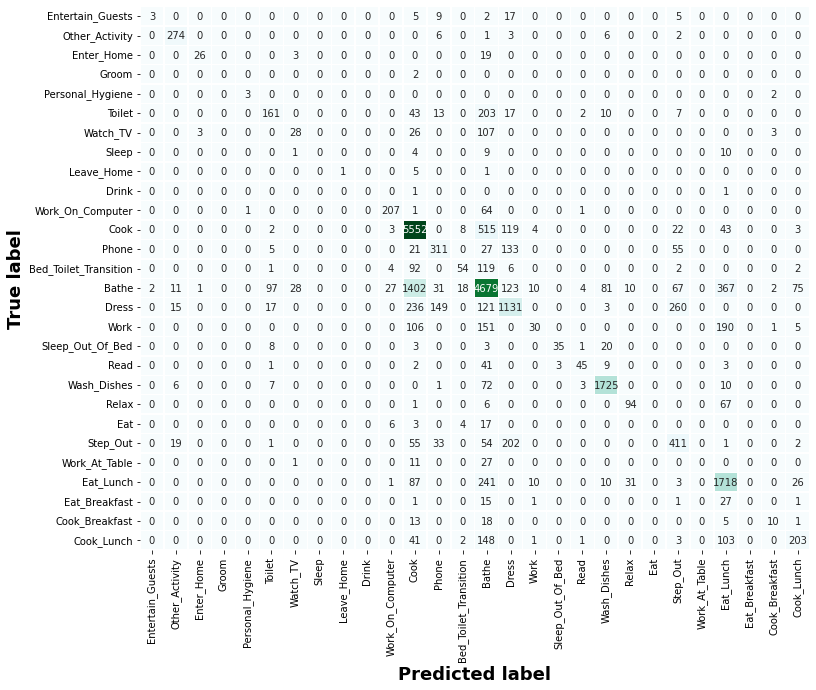

In [90]:
# matrix = classification_report(actual,predicted,labels=[1,0])
def classification_reportx(y_test,y_predicted):
  matrix = classification_report(y_test,y_predicted, labels=pd.unique(y_predicted))
  # matrix = classification_report(reverse_encoded_y_test,reverse_encoded_y_predicted, labels=pd.unique(reverse_encoded_y_predicted))
  print(matrix)
# classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)


# confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
def confusion_matrixx(y_test, y_pred,figsize1,figsize2):
  %matplotlib inline
  # fig, ax = plt.subplots(figsize=(12,10))
  fig, ax = plt.subplots(figsize=(figsize1,figsize2))
  # cm = confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
  cm = confusion_matrix(y_test, y_pred)
  # df_cm = pd.DataFrame(cm, index=pd.unique(reverse_encoded_y_test), columns=pd.unique(reverse_encoded_y_test))
  df_cm = pd.DataFrame(cm, index=pd.unique(y_test), columns=pd.unique(y_test))
  ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d", linewidths=.5, ax=ax)
  # plt.setp(ax.get_xticklabels(), rotation=45)
  plt.ylabel('True label', fontweight='bold', fontsize = 18)
  plt.xlabel('Predicted label', fontweight='bold', fontsize = 18) 
  plt.show()
# confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)

# class for Y convertions
class TextLabelEncoderDummy:

  def labelencoder(y_df):
    encoder = LabelEncoder()
    encoder.fit(y_df)
    encoded_Y = encoder.transform(y_df)
    return encoded_Y


  def encoded_to_dummy(encoded_Y):
    # convert encoder variable to dummy variable
    uniques, ids = np.unique(encoded_Y, return_inverse=True)
    dummy_y = np_utils.to_categorical(ids, len(uniques))
    # dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y


  def reverse_dummy_to_encoded(y_test):
    reverse_dummy = uniques[y_test.argmax(1)]
    return reverse_dummy


  def reverse_encoded_to_text(reverse_dummy):
    reverse_encoded = encoder.inverse_transform(reverse_dummy)
    return reverse_encoded

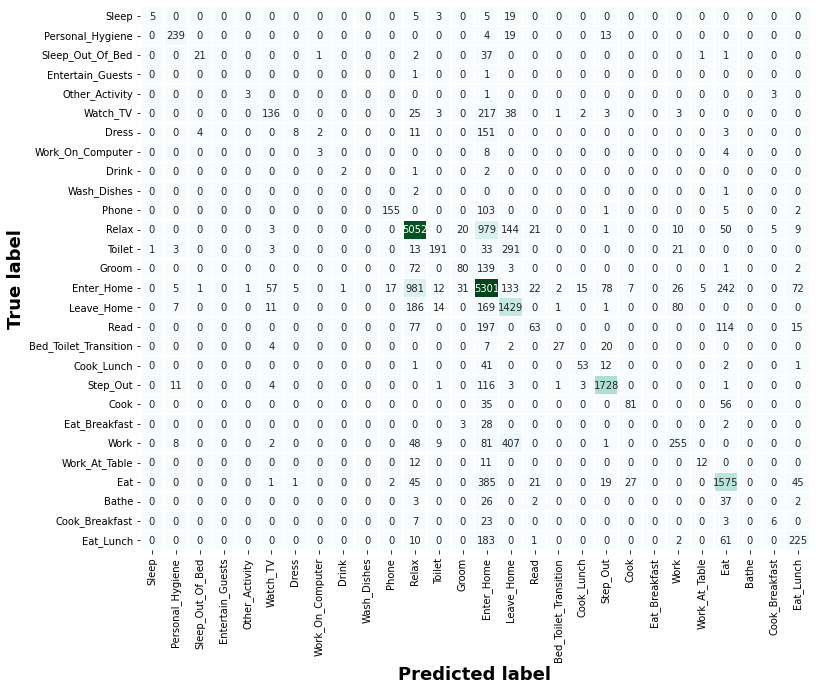

In [158]:
confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)

In [100]:
for i in range(len(reverse_encoded_y_test)):
    print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))

# pred = list()
# for i in range(4):
#     pred.append(uniques[predictions.argmax(1)])

Streaming output truncated to the last 5000 lines.
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Other_Activity -------- Predicted: (Entertain_Guests)
Test: Work_On_Computer -------- Predicted: (Work_On_Computer)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Watch_TV -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Leave_Home)
Test: Toilet -------- Predicted: (Personal_Hygiene)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Personal_Hygiene -------- Predicted: (Personal_Hygiene)
Test: Watch_TV -------- Predicted: (Watch_TV)
Test: Personal_Hygiene -------- Predicted: (Personal_Hygiene)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Sleep -------- Predicted: (Sleep)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Toilet -------- Predicted: (Toile

In [72]:
pd.unique(pred).shape

(1,)

In [ ]:
mp = ".\\Models\\banknote_model.h5"
model.save(mp)

In [ ]:
print(predictions, y_test)

In [66]:
for layer in model.layers:
    weights = layer.get_weights()

# from keras.utils import plot_model
# plot_model(model, to_file='/tmp/model.png', show_shapes=True,)


In [ ]:
def run_reg_withCrossV(X, y):
    model=DecisionTreeRegressor()
#     lr = LinearRegression()
#     lr = KNeighborsRegressor()
#     lr = lr.fit(trainx, y_train)
    model = LinearSVR()
    # define the direct multioutput wrapper model
    wrapper = MultiOutputRegressor(model)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#     n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    # force the scores to be positive
    n_scores = np.absolute(n_scores)
    # summarize performance
    print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
#     print(f"DecisionTreeRegressor Test socre {model.score(testx, y_test)}")
#     Y_pred2 = model.predict(testx)

def run_reg_makePred(X, y,X_t):
    model = LinearSVR()
    # define the direct multioutput wrapper model
    wrapper = RegressorChain(model)
    # fit the model on the whole dataset
    wrapper.fit(X, y)
    # make a single prediction
    row = [0.0,-0.294750,-0.995985,2.058876]
    yhat = wrapper.predict(X_t)
    # summarize the prediction
    print('Predicted: %s' % yhat[0])
    


In [58]:
# Now we can check the model’s performance on test data:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

array([0.71096587, 0.70778865, 0.71423382, 0.71895427, 0.71868193,
       0.70942265, 0.7243101 , 0.71033043, 0.70933187, 0.71169209])

In [ ]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output


In [ ]:
from google.colab import files
unique_numeric_features.to_csv('unique_numeric_features.csv') 
files.download("unique_numeric_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# qr52323694